In [1]:
#common imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
#Data Source: https://catalog.data.gov/dataset/gasoline-retail-prices-weekly-average-by-region-beginning-2007
data=pd.read_csv('Gasoline_Retail_Prices_Weekly_Average_by_Region__Beginning_2007.csv') 

data['Date'] = pd.to_datetime(data['Date'])
X = data['Date']
Y = data[['New York State Average ($/gal)']]

X.head, Y.head

(<bound method NDFrame.head of 0     2024-04-15
 1     2024-04-08
 2     2024-04-01
 3     2024-03-25
 4     2024-03-18
          ...    
 855   2007-11-26
 856   2007-11-19
 857   2007-11-12
 858   2007-11-05
 859   2007-10-29
 Name: Date, Length: 860, dtype: datetime64[ns]>,
 <bound method NDFrame.head of      New York State Average ($/gal)
 0                              3.47
 1                              3.46
 2                              3.46
 3                              3.41
 4                              3.35
 ..                              ...
 855                            3.28
 856                            3.26
 857                            3.21
 858                            3.10
 859                            2.98
 
 [860 rows x 1 columns]>)

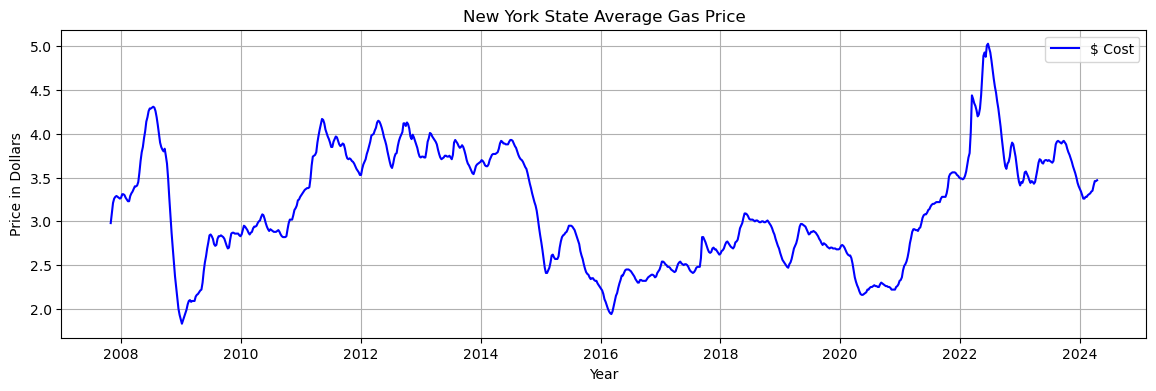

In [3]:
#graph of all data points
plt.rcParams['figure.figsize'] = [14,4]

plt.plot(X, Y, label="$ Cost", color="b")

plt.xlabel('Year')
plt.ylabel('Price in Dollars')
plt.legend()
plt.title('New York State Average Gas Price')
plt.grid(True)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [5]:
#convert to numpy arrays to reshape
X_train = X_train.values
X_train = np.reshape(X_train, (-1,1))
X_test = X_test.values
X_test = np.reshape(X_test, (-1,1))
Y_train = Y_train.values
Y_train = np.reshape(Y_train, (-1,1))
Y_test = Y_test.values
Y_test = np.reshape(Y_test, (-1,1))
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((688, 1), (172, 1), (688, 1), (172, 1))

In [6]:
#scale down time data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train = scaler.fit_transform(X_train)
scaled_test = scaler.fit_transform(X_test)

In [7]:
#convert data to pytorch tensors
X_train = torch.tensor(scaled_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)

X_test = torch.tensor(scaled_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

In [8]:
#create model
class MLModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(MLModel, self).__init__()
        self.model = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.linear = nn.Linear(hidden_size, 1) #one hidden layer
        
    def forward(self, x):
        out, _ = self.model(x)
        out = self.linear(out)
        return out

In [9]:
#model parameters
input_size = 1
num_layers = 2
hidden_size = 32
output_size = 1

model = MLModel(input_size, hidden_size, num_layers)

MSE = torch.nn.MSELoss(reduction='mean') #error measurement function

optimizer = torch.optim.Adam(model.parameters(), lr=0.01) #optimizer used

In [10]:
#training and testing
total_epochs = 30
train_hist = []
test_hist = []
for epoch in range(total_epochs):
    model.train() #training
    predictions = model(X_train)
    loss = MSE(predictions, Y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}/{total_epochs} has Training Loss of {loss.item()}')
    
    train_hist.append(loss.item())
    model.eval() #testing
    with torch.no_grad():
        predictions = model(X_test)
        loss = MSE(predictions, Y_test)
        
    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}/{total_epochs} has Testing Loss of {loss.item()}')
    test_hist.append(loss.item())   

Epoch 5/30 has Training Loss of 1.759590983390808
Epoch 5/30 has Testing Loss of 0.6608912348747253
Epoch 10/30 has Training Loss of 0.9196334481239319
Epoch 10/30 has Testing Loss of 0.9179167747497559
Epoch 15/30 has Training Loss of 0.5104517340660095
Epoch 15/30 has Testing Loss of 0.44230222702026367
Epoch 20/30 has Training Loss of 0.4935860335826874
Epoch 20/30 has Testing Loss of 0.4363422691822052
Epoch 25/30 has Training Loss of 0.499208003282547
Epoch 25/30 has Testing Loss of 0.4137765169143677
Epoch 30/30 has Training Loss of 0.4443592131137848
Epoch 30/30 has Testing Loss of 0.4141441285610199


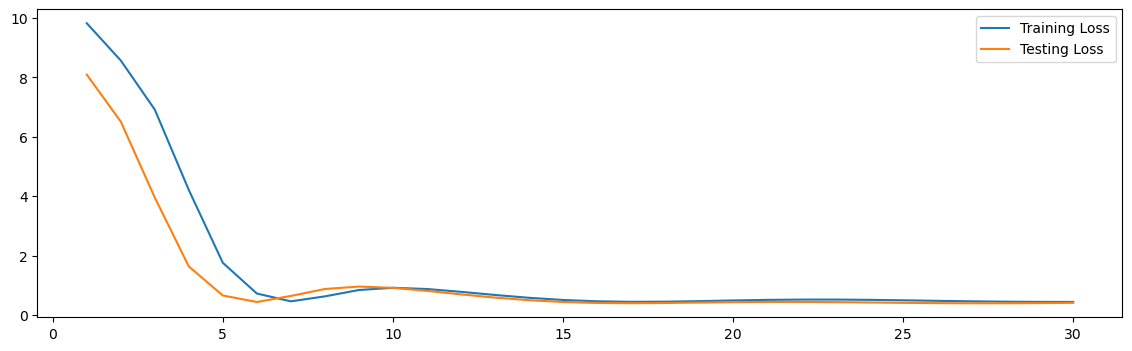

In [11]:
#plot error of training and testing
x = np.linspace(1, total_epochs, total_epochs)
plt.plot(x, train_hist, scalex=True, label='Training Loss')
plt.plot(x, test_hist, label='Testing Loss')
plt.legend()
plt.show()